In [89]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils import CircularAnnulus as can
from photutils import aperture_photometry
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)
from photutils import CircularAperture as ca
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models
from astropy.nddata import CCDData
import ccdproc
from astropy import units as u

In [2]:
biasfiles = [line.rstrip('\n') for line in open('bias.list')]

In [3]:
data_stack = []
for file in biasfiles:
    data_stack.append(fits.getdata(file))

In [4]:
medianBias = np.median(data_stack,axis=0)
header = fits.getheader(biasfiles[0])

In [5]:
header['HISTORY'] = 'Median combined'

In [6]:
fits.writeto('Wolf1346bias.fits', medianBias, header, overwrite=True)

In [7]:
!ls flat.00??.fits > files_with_bias.list
!ls wolf1346_.000?.fits >> files_with_bias.list
!ls wolf1346_m.0001.fits >> files_with_bias.list

In [8]:
ls *.fits > allfiles.list

In [9]:
cp allfiles.list allfiles_os.list

And this is where it all goes horribly wrong

In [10]:
datafilesin = [line.rstrip('\n') for line in open('allfiles.list')]
datafilesout = [line.rstrip('\n') for line in open('allfiles_os.list')]
# print(datafilesout)
n = len(datafilesin)
for i in np.arange(n):
    data, header = fits.getdata(datafilesin[i], header=True)
    dataout = data_stack - medianBias
#     header['HISTORY'] = 'Bias subtracted'
#     print(type(fits))
    fits.writeto(datafilesout[i], dataout, overwrite=True)

TypeError: buffer is too small for requested array

It didn't get better. In fact, it crashed. Several times.

Photometry

In [90]:
positions = [(302, 620), (375,517), (460,537), (523,415), (297,506), (787,546), (157,385), (568,407), (935,357), (747,642)]
apertures = ca(positions,8)

In [91]:
image = fits.getdata('quadRU.fits')

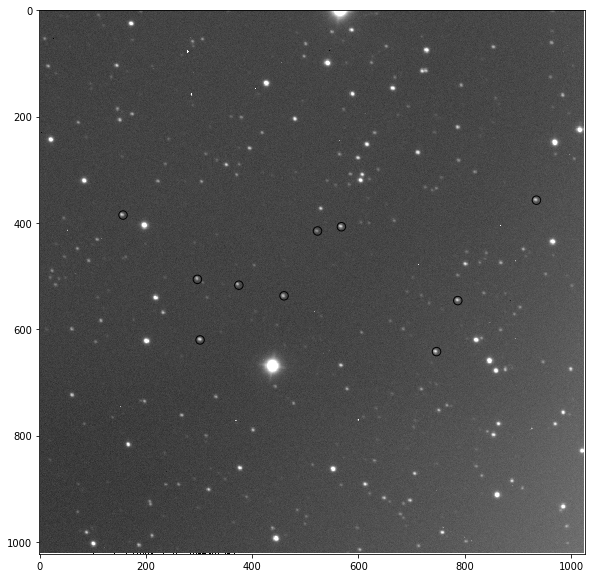

In [92]:
plt.figure(figsize = (10,10))
plt.imshow(image,cmap ='gray',norm=LogNorm(125,2000))
ca.plot(ca(positions,8))

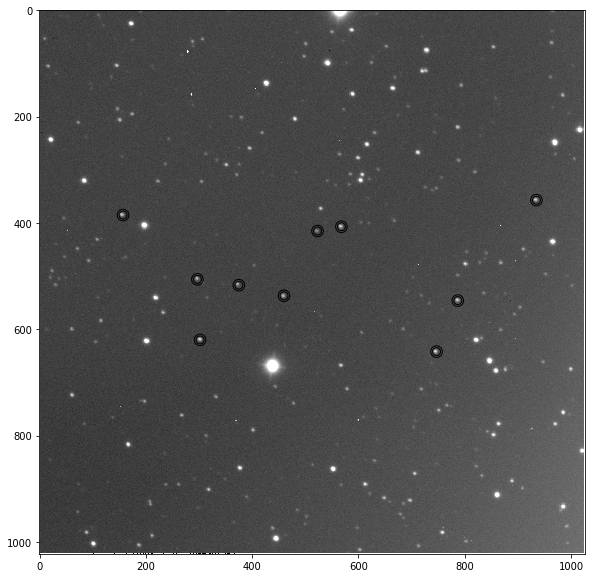

In [93]:
plt.figure(figsize = (10,10))
plt.imshow(image, cmap = 'gray',norm=LogNorm(125,2000))
can.plot(can(positions,7.5,11))

In [94]:
annulis = can(positions, r_in= 8, r_out= 10)
annulis

<CircularAnnulus([[302, 620],
                  [375, 517],
                  [460, 537],
                  [523, 415],
                  [297, 506],
                  [787, 546],
                  [157, 385],
                  [568, 407],
                  [935, 357],
                  [747, 642]], r_in=8.0, r_out=10.0)>

In [95]:
aperture_values= aperture_photometry(image, annulis, method = 'center')

In [96]:
mean_background = aperture_values['aperture_sum']/annulis.area()

In [97]:
aperture_value=aperture_photometry(image,apertures,method= 'center')
a=mean_background*apertures.area()
sub_background = aperture_value['aperture_sum']-a

In [98]:
apers = (apertures, annulis)
phot_table = aperture_photometry(image, apers)
phot_table['residual_aperture_sum'] = sub_background
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,residual_aperture_sum
,pix,pix,,,
int64,float64,float64,float64,float64,float64
1,302.0,620.0,83203.84072399413,29764.14417841743,28361.300628481382
2,375.0,517.0,69676.78404489881,30012.69471253785,14580.39784260068
3,460.0,537.0,70566.8999970074,29911.84676035178,15706.701589603414
4,523.0,415.0,62975.72815297581,30178.3040590807,7579.516190574977
5,297.0,506.0,69591.31904472124,30091.304565638355,14365.220549078018
6,787.0,546.0,85872.69750356248,32794.530239895976,25551.31317052831
7,157.0,385.0,77421.88291276203,29996.404351339097,22410.395884112542
8,568.0,407.0,79959.13743073658,30671.126973107355,23690.42465517189


In [99]:
#Assisted greatly by Yujin
avg_count = []
methods = ['center', 'subpixel']
radii = np.linspace(5, 25, 20)
for i_method in methods:
    avg_count_radii = []
    for i_radius in radii:
        aperture = ca(positions, r=i_radius)
        annulus = can(positions, r_in=(i_radius+8), r_out=(i_radius+15))
        center = aperture_photometry(image, aperture, method=i_method)
        center_annulus = aperture_photometry(image, annulus, method=i_method)
        bkg_mean = center_annulus['aperture_sum'] / annulus.area()
        bkg_sum = bkg_mean * aperture.area()
        final_sum = center['aperture_sum'] - bkg_sum
        center['residual_aperture_sum'] = final_sum
        avg_count_radii.append((final_sum / apertures.area())[3])
    avg_count.append(avg_count_radii)

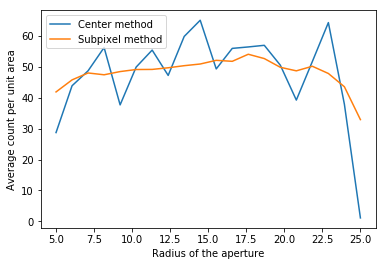

In [100]:
plt.plot(radii, avg_count[0], label='Center method')
plt.plot(radii, avg_count[1], label='Subpixel method')
plt.ylabel('Average count per unit area')
plt.xlabel('Radius of the aperture')
plt.legend(loc=2);

In [101]:
sigma_psf=2.0
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)

In [102]:
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                 group_maker=daogroup,
                                                 bkg_estimator=mmm_bkg,
                                                 psf_model=psf_model,
                                                 fitter=LevMarLSQFitter(),
                                                 niters=1, fitshape=(11,11))
result_tab = photometry(image=image)
residual_image = photometry.get_residual_image()

In [103]:
pos = Table(names=['x_0', 'y_0'], data=[sources['x_mean'],
                                         sources['y_mean']])

In [104]:
photometry = BasicPSFPhotometry(group_maker=daogroup,
...                                 bkg_estimator=mmm_bkg,
...                                 psf_model=psf_model,
...                                 fitter=LevMarLSQFitter(),
...                                 fitshape=(11,11))
>>> result_tab = photometry(image=image, init_guesses=pos)
>>> residual_image = photometry.get_residual_image()
result_tab

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64
12,15,-182.0842735404993,1,1,15.18786046010133,11.215596670736396,-384.69042124566056,0.0,0.0,0.0
17,15,-209.41429427551583,2,1,15.649685875954441,6.027570124243766,195.43767074090144,0.0,0.0,0.0
12,20,-156.89386002103527,3,1,10.287233000610252,22.01434873074562,-169.3482574859471,0.0,0.0,0.0
17,20,-88.3162515404101,4,1,15.78245525129903,21.515652780645418,-100.7581322348954,0.0,0.0,0.0


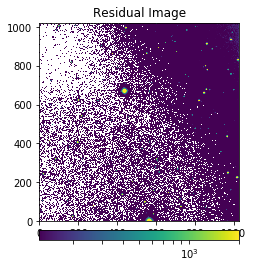

In [105]:
plt.subplot()
>>> plt.imshow(residual_image, cmap='viridis', aspect=1,
...            interpolation='nearest', origin='lower', norm=LogNorm(125,2000))
>>> plt.title('Residual Image')
>>> plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04);

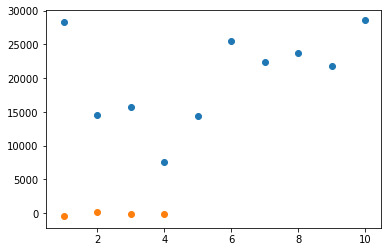

In [106]:
fig, ax = plt.subplots()
ax.scatter(phot_table["id"], phot_table["residual_aperture_sum"])
ax.scatter(result_tab["id"], result_tab["flux_fit"])
plt.show()